#Summer Project by Sam and Oisín

###Import modules

In [ ]:
#!pip3 install plotly --upgrade

In [ ]:
#update plotly
#!pip3 install plotly.express --upgrade

In [ ]:
#import modin.pandas as pd #a faster version of pandas that runs on multiple cores
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table #to read the .FITS file
from tqdm.notebook import tqdm  
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import timeit
num=0
from google.colab import drive
import os
drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/Summer Project')
os.chdir('/content/drive/MyDrive/Herschel')

Mounted at /content/drive


#Section A Calculating the S statistic

In [ ]:
#Herschel Submm Data
dat1 = Table.read('COSMOS_SPIRE250_cat_MF.fits', format='fits')
herschel_data = dat1.to_pandas()

#VLA Data
dat2 = Table.read('COSMOS_VLA.dat', format='ascii') 
vla_data = dat2.to_pandas()
vla_data.columns = ['ID','Project','Time','RA','RA_ERR','DEC', #Rename Columns #
                    'DEC_ERR','flux','flux_err','RMS',
                    'SNR','NPIX','RES','Multi']
vla_data.head(2)

,ID,Project,Time,RA,RA_ERR,DEC,DEC_ERR,flux,flux_err,RMS,SNR,NPIX,RES,Multi
0,78,COSMOSVLA3,J095709.33+020940.7,149.288886,0.010,2.161331,0.010,13400.0,670.0,28.7,385.0,104,1,0
1,1110,COSMOSVLA3,J095709.83+015457.4,149.290996,0.021,1.915946,0.021,1190.0,64.0,22.1,29.0,102,1,0


Plot of VLA Radio fluxes.

In [ ]:
px.histogram(vla_data.sort_values(by=['flux']),x='flux',range_x=[0,600],range_y=[0,2000],nbins=20000) #histogram of radio fluxes

##Herschel Data


Herschel Data Matched with VLA Data with a max radius of 10 arseconds

In [ ]:
#Herschel Data Matched with VLA Data with a max radius of 10 arseconds

dat3 = Table.read(f'Herschel_Subset.fits', format='fits') #read in matched data
m = dat3.to_pandas() #convert table to dataframe
m.rename(columns={"col1": "ID_match","col2": "Project_match", #rename columns
                        "col3": "Time_match","col4": "RA_match",
                        "col5": "RA_ERR_match","col6": "DEC_match",
                        "col7": "DEC_ERR_match","col8": "flux_match",
                        "col9": "flux_err_match","col10": "RMS_match",
                        "col11": "SNR_match","col12": "NPIX_match",
                        "col13": "RES_match","col14": "Multi_match",
                        },inplace=True)

#Concatinate vla_data and matched sources for faster calculations
vla_1 = vla_data[['flux']]
match = pd.concat([ vla_1,m ],axis=1) #concatinate vla_data and matched data for dataframe vectorisation
match.head(2)

,flux,RA,Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA_match,RA_ERR_match,DEC_match,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation
0,13400.0,149.260046,2.672311,0.022570,0.002684,0.021571,0.002613,0.016109,0.002667,0.801332,0.955032,149.259210,2.674810,0.017811,0.002543,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,1190.0,149.260324,2.672034,0.021641,0.002625,0.020708,0.002613,0.016109,0.002667,0.782787,0.954093,149.259213,2.669811,0.017740,0.002531,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


(0.0, 600.0)

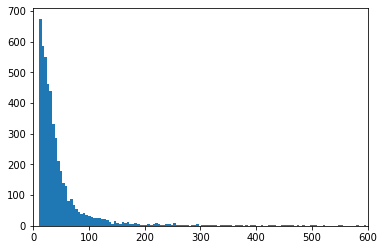

In [ ]:
#plt.hist(match['flux'],bins=10000)
#plt.xlim(0,600)
#plt.figure()
plt.hist(match['flux_match'],bins=10000)
plt.xlim(0,600)

Text(0.5, 0, 'Separation (arcsec)')

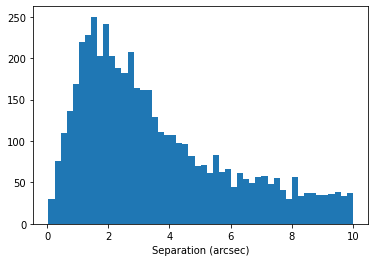

In [ ]:
plt.hist(match['Separation'],bins=50)
plt.xlabel('Separation (arcsec)')

In [ ]:
px.histogram(match,x=match['Separation'],nbins=100)

##Vectorisation functions

In [ ]:
#Max flux_match value 46200.0  Max Radio value 80300.0
#vectorisation #matched10 1379 values
def stat(vla, match, distance): #function to calculate s stat
  area=6228*5940 #measured dRA and dDEC
  num_flux= ( vla.to_numpy() > match.to_numpy()[:,None]).sum(axis=1) #number of VLA sources with flux greater than matched flux
  #print(num_flux)
  surface_density= num_flux/area #density: number of high flux stars per area
  s= 1-np.exp(-1*np.pi*distance**2*surface_density) #S statistic caluation 0 indicates a very good counterpart and 1 indicates a poor counterpart
  return s

#Normalise S statistic
def norm(df):
  df=(df - df.min()) / (df.max() - df.min()) #normalisation calculation over dataframe column
  return df

#Optimise S statistic cut-off at 5%
def optimise_s(real,rand):  #function to find S threshold so that there is a 95% purity
  ratio_s=1
  filter=0.228 #initial threshold
  while ratio_s>0.05: #loop till purity is above 95%
    filter-=0.001 #stepsize
    number_s=[]
    for idx,source in real.iterrows(): #iterate through matched sources
      if source['s_norm']>filter: #go back to while if s value is greater than threshold
        continue
      #finds the number of random sources with s less than the s value of our source.
      num_rand = rand['s_r_norm'][ rand['s_r_norm'] < source['s_norm'] ].count() #number of random sources with better S value than the real sources
      number_s.append(num_rand)
    avg_s = np.mean(number_s) #find avg number of random sources with better S value than real source
    ratio_s = avg_s/rand['s_r_norm'].count() #find proportion of random sources with S values better than real sources, we want this to be under 0.05
    print(f's-limit: {round(filter,5)}, result:{round(ratio_s,5)}')
  prop = avg_s/ real['s_norm'].count()
  print(f'Final s-limit is: {round(filter,5)}, with result:{round(ratio_s,5)}, this removes {round(prop,5 )} of the data \n\n')
  print(f'threshold value of s-{round(filter,5)}')
  return filter

  #Optimise S statistic cut-off at 5%
def acc_optimise_s(real,rand,filter,stepsize):  #optimising function that allows to change stepsize and initial threshold value for more accurate calculations
  ratio_s=1
  while ratio_s>0.05: #loop till purity is above 95%
    filter-=stepsize
    number_s=[]
    for idx,source in real.iterrows(): #iterate through matched sources
      if source['s_norm']>filter: #go back to while if s value is greater than threshold
        continue
      #finds the number of random sources with s less than the s value of our source.
      num_rand = rand['s_r_norm'][ rand['s_r_norm'] < source['s_norm'] ].count()
      number_s.append(num_rand)
    avg_s = np.mean(number_s) #find avg number of random sources with better S value than real source
    ratio_s = avg_s/rand['s_r_norm'].count() #find proportion of random sources with S values better than real sources, we want this to be under 0.05
    print(f's-limit: {round(filter,5)}, result:{round(ratio_s,5)}')
  prop = avg_s/ real['s_norm'].count()
  print(f'Final s-limit is: {round(filter,5)}, with result:{round(ratio_s,5)}, this removes {round(prop,5 )} of the data \n\n')
  print(f'threshold value of s-{round(filter,5)}')

###Calculation of S values on Herschel Data

Input matched Herschel and VLA data to calculate S statistic. <br>
Normalise the S statistic from 0 to 1.

In [ ]:
#Calucate S statistic for matched sources at 10 arcsec
match['s']= stat(
          match['flux'], 
          match['flux_match'], 
          match['Separation'].values
          )
match['s_norm'] = norm(match['s']) #normalise S statistic for probability distribution
print(match['s_norm'].head(2))
px.histogram(match,x=match['s_norm'],nbins=200)

0   NaN
1   NaN
Name: s_norm, dtype: float64


In [ ]:
px.scatter(match,x='flux_match',y='s_norm')

In [ ]:
px.scatter(match,x='F_BLIND_MF_SPIRE_250',y='s_norm')

##Random Radio Data
Generate Monte Carlo simulation of the VLA Radio data to test the counterpart false matches rate. The data-set comprises of radio sources at random positions, the fluxes of the radio sources are taken from the VLA data. <br>
We match the Herschel sources to the Monte Carlo sources to find the expected number of random matches.

In [ ]:
#import Monte Carlo simulation 
#dat = Table.read(f'Random_matches/matches.fits', format='fits')
dat = Table.read(f'/content/drive/MyDrive/Herschel/Random_matches/rand_6.fits', format='fits')

rand_0 = dat.to_pandas() #convert table to dataframe
rand_0.drop('col1',axis=1,inplace=True) #remove null columns
rand_0 = rand_0.rename(columns={"flux": "flux_match",'col8':'flux_match'}) #rename columns 

r1 = rand_0[['flux_match','Separation']] #make into one dataframe for vectorisation
random = pd.concat([ vla_1,r1 ],axis=1) #concatinate to speed up calculations
random.info()
rand_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10830 entries, 0 to 10829
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   flux        10830 non-null  float64
 1   flux_match  1339 non-null   float32
 2   Separation  1339 non-null   float64
dtypes: float32(1), float64(2)
memory usage: 211.6 KB


,RA_1,Dec_1,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,RA_2,Dec_2,flux_match,GroupID,GroupSize,Separation
0,150.654900,3.025770,0.023591,0.003114,0.011983,0.003144,0.004028,0.003162,0.682016,0.966388,150.654065,3.024937,0.019480,0.003045,150.657178,3.025001,14.600000,<NA>,<NA>,8.646222
1,150.934157,2.097966,0.027051,0.002550,0.015193,0.002552,0.003025,0.002561,0.780274,0.985784,150.933879,2.098244,0.028763,0.002481,150.932552,2.099542,25.100000,<NA>,<NA>,8.094997
2,150.221549,2.620389,0.038172,0.002508,0.027425,0.002582,0.006601,0.002473,0.797041,0.988688,150.221827,2.620111,0.039010,0.002441,150.223187,2.619173,26.299999,<NA>,<NA>,7.338690
3,149.294517,2.676223,0.020610,0.002548,0.026433,0.002542,0.014409,0.002653,0.935261,0.964395,149.294239,2.676501,0.019105,0.002480,149.295921,2.676616,46.000000,1,2,5.242437
4,149.716868,1.619825,0.076135,0.002509,0.040893,0.002480,0.012311,0.002536,0.824500,1.000000,149.716590,1.620103,0.070907,0.002442,149.714769,1.618819,60.200001,2,2,8.378331


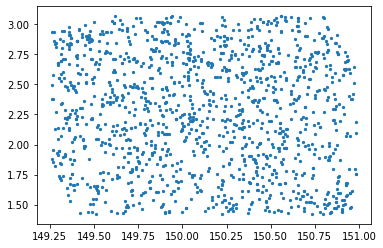

In [ ]:
plt.scatter(rand_0['RA_2'],rand_0['Dec_2'],s=5)

Input matched Herschel and Random sources to calculate S statistic.
Normalise the S statistic from 0 to 1.

In [ ]:
px.histogram(x=match['s'],nbins=200,opacity=0.5)

###Calculation of S values on the Random Radio Data

In [ ]:
random['s_r']= stat(random['flux'],random['flux_match'],random['Separation'].values) #Calculate S statistic for Monte Carlo matches
random['s_r_norm'] = norm( random['s_r']) #Normalise s for Monte Carlo matches 
fig = go.Figure() #plot Random s distribution with Real s distribution
fig.add_trace(go.Histogram(x=match['s'],name='Real',nbinsx=200,opacity=0.5))
fig.add_trace(go.Histogram(x=random['s_r'],name='Random',opacity=0.5,nbinsx=200))
fig.update_layout(barmode='overlay')
fig.show()

##Normalisation of S values for Herschel and Random Radio Data
Compare the Normalised S statistics for the Real and Random Matches. <br>
We can see after normalisation the s values are closer to what we expect.

In [ ]:
fig = go.Figure() #plot normalise S values
fig.add_trace(go.Histogram(x=match['s_norm'],name='Real Normalised',nbinsx=200)) #normalised Real s values
fig.add_trace(go.Histogram(x=random['s_r_norm'],name='Random Normalised',opacity=0.5,nbinsx=200)) #normalised Monte Carlo s values
fig.update_layout(barmode='overlay')
fig.show()

#Section B: Optimising the S statistic threshold

###Sample Optimisation of S threshold for Random Radio Data

Optimise the S statistic to find the 5% thresholf

In [ ]:
#Concatinate Real and Random for vectorisation to Optimise the S statistic threshold value
t1 = random[['s_r','s_r_norm']] #Concatinate for vectorisation and faster calculation
test_random_real = pd.concat([ match,t1 ],axis=1) #concatinate matched dataset with s values for the monte carlo simulation
test_random_real.head(2)

,flux,RA,Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA_match,RA_ERR_match,DEC_match,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation,s,s_norm,s_r,s_r_norm
0,13400.0,149.260046,2.672311,0.022570,0.002684,0.021571,0.002613,0.016109,0.002667,0.801332,0.955032,149.259210,2.674810,0.017811,0.002543,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,0.054461,0.631498
1,1190.0,149.260324,2.672034,0.021641,0.002625,0.020708,0.002613,0.016109,0.002667,0.782787,0.954093,149.259213,2.669811,0.017740,0.002531,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,0.030542,0.354114


s-limit: 0.178, result:0.05196
s-limit: 0.176, result:0.05154
s-limit: 0.174, result:0.05121
s-limit: 0.172, result:0.05092
s-limit: 0.17, result:0.05043
s-limit: 0.168, result:0.05018
s-limit: 0.166, result:0.04974
0.01346 


threshold value of s-0.166


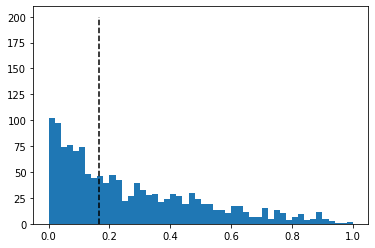

In [ ]:
#For loop version of S threshold optimisation
ratio_s=1
filter1=0.18
while ratio_s>0.05: #purity of 95%
  filter1-=0.002 #stepsize
  number_s=[]
  
  for idx,source in test_random_real.iterrows(): #iterate through real sources
    if source['s_norm']>filter1: #go back to while if source s value is greater than threshold
      continue
    #finds the number of random sources with s less than the s value of our source.
    num_rand = test_random_real['s_r_norm'][ test_random_real['s_r_norm'] < source['s_norm'] ].count() #number of Monte Carlo sources with S values better than real sources
    number_s.append(num_rand)
  avg_s = np.mean(number_s) #avg number of Monte Carlo sources with S values better than Real sources
  ratio_s = avg_s/test_random_real['s_r_norm'].count() #proportion of Monte Carlo sources with S value better than the real sources
  print(f's-limit: {round(filter1,5)}, result:{round(ratio_s,5)}') #we want ratio_s to be less than 0.05 so that 95% of the random sources have a worse S value than the real sources
  
#filter1=0.166
print(round(avg_s/match['s_norm'].count(),5),'\n\n')
print(f'threshold value of s-{round(filter1,5)}')
plt.hist(random['s_r_norm'],bins=50)
plt.vlines(filter1,ymin=0,ymax=200,ls='--')

In [ ]:
s5rand = test_random_real.s_r_norm.quantile(0.05) #S value that includes 5% of the random sources
s10rand = test_random_real.s_r_norm.quantile(0.1) #S value that includes 10% of the random sources]
filter1=0.166
s5rand,s10rand #(0.009698651304308525, 0.01983451951037176)

(0.010948299030925672, 0.025542261948406537)

In [ ]:
fig = px.histogram(test_random_real,x='s_norm',nbins=2000) #histogram of S values for real sources

fig.add_trace(go.Histogram(x=random['s_r_norm'],name='random',opacity=0.5,nbinsx=2000)) #histogram of S values for Monte Carlo sources
fig.update_layout(barmode='overlay')
fig.add_shape(type="line",                  #threshold line
    x0=filter1, y0=0, x1=filter1, y1=200,
    line=dict(color="MediumPurple",
              width=1.5,
              dash="dot"))
fig.add_shape(type="line",                  #5% of random sources
    x0=s5rand, y0=0, x1=s5rand, y1=200,
    line=dict(color="black",
              width=1.5,
              dash="dot"))
fig.add_shape(type="line",                  #5% of random sources
    x0=s10rand, y0=0, x1=s10rand, y1=200,
    line=dict(color="black",
              width=1.5,
              dash="dot"))
fig.show()


In [ ]:
rand = test_random_real.sort_values(by=['s_r_norm']) #1251
rand['s_r_norm'][0:60] #print first 5% of random data 

7789    0.000000
4213    0.000038
255     0.000338
81      0.000387
207     0.000415
7836    0.000424
7801    0.000821
7679    0.000866
1835    0.000944
243     0.001017
16      0.001078
7716    0.001079
3222    0.001349
7670    0.001401
5132    0.001518
5907    0.001663
1681    0.002126
7400    0.002314
260     0.002637
246     0.002703
2040    0.002785
250     0.003234
2485    0.003732
36      0.003982
4983    0.004042
5928    0.004073
172     0.004124
1519    0.004186
4264    0.004469
290     0.004500
187     0.004525
7658    0.004647
90      0.004881
379     0.004898
3437    0.004971
3889    0.004978
7524    0.004988
615     0.005055
7234    0.005121
1515    0.005144
5287    0.005237
884     0.005357
92      0.005434
7624    0.005587
7525    0.006043
7700    0.006125
199     0.006158
1264    0.006323
7477    0.006369
277     0.006502
4148    0.006782
7645    0.006854
2882    0.008031
7678    0.008166
94      0.008261
7539    0.008988
55      0.009163
7523    0.009183
293     0.0092

Proportion of data less within the threshold

In [ ]:
filter1

0.166

In [ ]:
s1 = test_random_real[test_random_real['s_norm']< filter1] #Sources with S value less than threshold
s1['s_norm'].count()/test_random_real['s_norm'].count() #Proportion of total sources with value of S less than threshold

0.8091772791590863

In [ ]:
s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4003 entries, 106 to 8432
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flux                      4003 non-null   float64
 1   RA                        4003 non-null   float64
 2   Dec                       4003 non-null   float64
 3   F_BLIND_MF_SPIRE_250      4003 non-null   float64
 4   FErr_BLIND_MF_SPIRE_250   4003 non-null   float64
 5   F_BLIND_MF_SPIRE_350      4003 non-null   float64
 6   FErr_BLIND_MF_SPIRE_350   4003 non-null   float64
 7   F_BLIND_MF_SPIRE_500      4003 non-null   float64
 8   FErr_BLIND_MF_SPIRE_500   4003 non-null   float64
 9   r                         4003 non-null   float64
 10  P                         4003 non-null   float64
 11  RA_pix                    4003 non-null   float64
 12  Dec_pix                   4003 non-null   float64
 13  F_BLIND_pix_SPIRE_250     4003 non-null   float64
 14  FErr_B

In [ ]:
#filter1 at 0.166
val1 = test_random_real['s_norm'][ test_random_real['s_norm']< filter1 ].count() #number of real sources within threshold
val2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< filter1 ].count() #number of random sources within threshold
print(f'There are {round(val1,5)} sources with S less than {round(filter1,5)},\nThere are {round(val2,5)} random sources with S less than {round(filter1,5)}, \nSo there are {round(val1-val2,5)} Real sources less than {round(filter1,5)}, \nSo of sources with S less than {round(filter1,5)}, {round( (val1-val2)/val1,5)} of them are real, \nOr as a percentage {round(100*(val1-val2)/val1,5)}% of the sources with S less than {round(filter1,5)} are Real ')

There are 4003 sources with S less than 0.166,
There are 598 random sources with S less than 0.166, 
So there are 3405 Real sources less than 0.166, 
So of sources with S less than 0.166, 0.85061 of them are real, 
Or as a percentage 85.0612% of the sources with S less than 0.166 are Real 


In [ ]:
#All the data
val1 = test_random_real['s_norm'][ test_random_real['s_norm']< 1 ].count() #number of real sources within threshold
val2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< 1 ].count() #number of random sources within threshold
print(f'There are {round(val1,5)} sources with S less than {round(1,5)},\nThere are {round(val2,5)} random sources with S less than {round(1,5)}, \nSo there are {round(val1-val2,5)} Real sources less than {round(1,5)}, \nSo of sources with S less than {round(1,5)}, {round( (val1-val2)/val1,5)} of them are real, \nOr as a percentage {round(100*(val1-val2)/val1,5)}% of the sources with S less than {round(1,5)} are Real ')

There are 4946 sources with S less than 1,
There are 1338 random sources with S less than 1, 
So there are 3608 Real sources less than 1, 
So of sources with S less than 1, 0.72948 of them are real, 
Or as a percentage 72.94784% of the sources with S less than 1 are Real 


In [ ]:
val = test_random_real['s_r'][ test_random_real['s_r'] < test_random_real['s'] ].count() / test_random_real['s'].count()
val #proportion of the Monte Carlo sources with S values better than the real sources for the Total sources

0.02971497877501516

5%

In [ ]:
print('S threshold for 5% of random data:',s5rand)

S threshold for 5% of random data: 0.010948299030925672


In [ ]:
val5_1 = test_random_real['s_norm'][ test_random_real['s_norm']< s5rand ].count() #number of real sources within threshold
val5_2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< s5rand].count() #number of random sources within threshold
print(f'There are {round(val5_1,5)} sources with S less than {round(s5rand,5)},\nThere are {round(val5_2,5)} random sources with S less than {round(s5rand,5)}, \nSo there are {round(val5_1-val5_2,5)} Real sources less than {round(s5rand,5)}, \nSo of sources with S less than {round(s5rand,5)}, {round( (val5_1-val5_2)/val5_1,5)} of them are real, \nOr as a percentage {round(100*(val5_1-val5_2)/val5_1,5)}% of the sources with S less than {round(s5rand,5)} are Real ')

There are 1530 sources with S less than 0.01095,
There are 67 random sources with S less than 0.01095, 
So there are 1463 Real sources less than 0.01095, 
So of sources with S less than 0.01095, 0.95621 of them are real, 
Or as a percentage 95.62092% of the sources with S less than 0.01095 are Real 


10%

In [ ]:
print('S threshold for 10% od random data:',s10rand)

S threshold for 10% od random data: 0.025542261948406537


In [ ]:
val10_1 = test_random_real['s_norm'][ test_random_real['s_norm']< s10rand ].count() #number of real sources within threshold
val10_2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< s10rand].count() #number of random sources within threshold
print(f'There are {round(val10_1,5)} sources with S less than {round(s10rand,5)},\nThere are {round(val10_2,5)} random sources with S less than {round(s10rand,5)}, \nSo there are {round(val10_1-val10_2,5)} Real sources less than {round(s10rand,5)}, \nSo of sources with S less than {round(s10rand,5)}, {round( (val10_1-val10_2)/val10_1,5)} of them are real, \nOr as a percentage {round(100*(val10_1-val10_2)/val10_1,5)}% of the sources with S less than {round(s10rand,5)} are Real ')

There are 2282 sources with S less than 0.02554,
There are 134 random sources with S less than 0.02554, 
So there are 2148 Real sources less than 0.02554, 
So of sources with S less than 0.02554, 0.94128 of them are real, 
Or as a percentage 94.12796% of the sources with S less than 0.02554 are Real 


###Optimise S threshold for 100 Random Radio datasets
**Warning**: This code will run for over 10 minutes

In [ ]:
mean_s_max=[]
from google.colab import drive
import os
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/Summer Project/Random_matches')
os.chdir('/content/drive/MyDrive/Herschel/Random_matches')
for i in tqdm(range(100)): #iterate through the 100 Monte Carlo sources
  dat0 = Table.read(f'rand_{i}.fits', format='fits') #import random data
  rand = dat0.to_pandas() #convert table to dataframe
  rand.drop('col1',axis=1,inplace=True) #drop null columns
  rand = rand.rename(columns={"flux": "flux_match"}) #rename columns

  #Calcuate normalised S statistic 
  rand['s_r']= stat( vla_data['flux'], rand['flux_match'], rand['Separation'].values )
  rand['s_r_norm'] = norm( rand['s_r'])

  #Optimise S
  filter=optimise_s( match, rand ) #(s_norm,s_r_norm)
  mean_s_max.append(filter)

print(mean_s_max)
print('The average threshold value of s is-',round(np.mean(mean_s_max),5)) 

In [ ]:
s_rand = [0.15099999999999997, 0.15199999999999997, 0.15299999999999997, 0.15199999999999997, 0.14399999999999996, 0.15799999999999997, 0.16699999999999998, 0.15499999999999997, 0.179, 0.15999999999999998, 0.221, 0.191, 0.16499999999999998, 0.15699999999999997, 0.15999999999999998, 0.16299999999999998, 0.13199999999999995, 0.14999999999999997, 0.15499999999999997, 0.175, 0.16499999999999998, 0.181, 0.13399999999999995, 0.15799999999999997, 0.14299999999999996, 0.179, 0.16599999999999998, 0.15699999999999997, 0.15499999999999997, 0.16299999999999998, 0.14499999999999996, 0.13899999999999996, 0.15199999999999997, 0.14899999999999997, 0.15899999999999997, 0.14799999999999996, 0.14899999999999997, 0.15099999999999997, 0.16299999999999998, 0.16199999999999998, 0.13899999999999996, 0.15999999999999998, 0.16699999999999998, 0.15099999999999997, 0.15599999999999997, 0.15799999999999997, 0.15999999999999998, 0.15399999999999997, 0.16699999999999998, 0.15599999999999997, 0.17099999999999999, 0.15099999999999997, 0.14699999999999996, 0.16099999999999998, 0.177, 0.18, 0.15199999999999997, 0.15799999999999997, 0.15699999999999997, 0.17099999999999999, 0.15999999999999998, 0.14699999999999996, 0.14699999999999996, 0.15799999999999997, 0.16499999999999998, 0.191, 0.14599999999999996, 0.201, 0.14599999999999996, 0.16799999999999998, 0.174, 0.15499999999999997, 0.14499999999999996, 0.14399999999999996, 0.15099999999999997, 0.16099999999999998, 0.15999999999999998, 0.15599999999999997, 0.14899999999999997, 0.186, 0.15999999999999998, 0.13699999999999996, 0.15799999999999997, 0.15499999999999997, 0.16099999999999998, 0.16599999999999998, 0.15799999999999997, 0.15899999999999997, 0.16299999999999998, 0.16199999999999998, 0.14799999999999996, 0.15199999999999997, 0.15999999999999998, 0.183, 0.16299999999999998, 0.15899999999999997, 0.14499999999999996, 0.14099999999999996, 0.15099999999999997, 0.16699999999999998]
missing = [10]

In [ ]:
np.median(s_rand)

0.15799999999999997

In [ ]:
np.mean(s_rand)

0.15908999999999998

###Calculate average 5% and 10% s threshold value for 100 Random sources

In [ ]:
s5 = np.zeros(100)
s10 = np.zeros(100)
from google.colab import drive
import os
os.chdir('/content/drive/MyDrive/Herschel/Random_matches')
for i in tqdm(range(100)): #iterate through the 100 Monte Carlo sources
  dat0 = Table.read(f'rand_{i}.fits', format='fits') #import random data
  rand = dat0.to_pandas() #convert table to dataframe
  rand.drop('col1',axis=1,inplace=True) #drop null columns
  rand = rand.rename(columns={"flux": "flux_match"}) #rename columns

  #Calcuate normalised S statistic 
  rand['s_r']= stat( vla_data['flux'], rand['flux_match'], rand['Separation'].values )
  rand['s_r_norm'] = norm( rand['s_r'])
  s5[i] = rand.s_r_norm.quantile(0.05) #S value that includes 5% of the random sources
  s10[i] = rand.s_r_norm.quantile(0.1) #S value that includes 10% of the random sources


print(s10)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.01983452 0.02087354 0.02295867 0.02135969 0.01819767 0.0222657
 0.02554226 0.0228338  0.02737372 0.0229021  0.03321764 0.02784767
 0.02210427 0.02432456 0.02131622 0.02315898 0.01992585 0.02005773
 0.02049496 0.02069785 0.02557127 0.02467294 0.01778727 0.02265214
 0.02072744 0.02742505 0.02329027 0.02266047 0.02290267 0.02433782
 0.02045877 0.02000867 0.02306913 0.02216352 0.02239649 0.02125239
 0.02001887 0.02069434 0.02454125 0.02349106 0.01749002 0.02297664
 0.02279567 0.02140324 0.02283986 0.02413786 0.02239305 0.02263871
 0.02332035 0.02330624 0.02323233 0.02145481 0.02269284 0.02129105
 0.02655692 0.02512358 0.0210719  0.02018968 0.02041984 0.02460812
 0.02303704 0.02087247 0.01969603 0.02532827 0.02419297 0.02650501
 0.02067685 0.02813118 0.02171721 0.0275151  0.02528836 0.02003049
 0.02218044 0.02098295 0.02078084 0.02136345 0.02046172 0.02278295
 0.02090865 0.02501434 0.01985368 0.01994731 0.02066088 0.02170867
 0.02186593 0.02399183 0.02349234 0.02220781 0.02593204 0.02671

In [ ]:
mean_s10 = np.mean(s10)
mean_s5 = np.mean(s5)
print('Average s value at 10% threshold: {}'.format(mean_s10) )
print('Average s value at 5%  threshold: {}'.format( mean_s5 ) )

Average s value at 10% threshold: 0.022629710163026406
Average s value at 5%  threshold: 0.009684684073114055


Average 5% threshold

In [ ]:
val5_1 = test_random_real['s_norm'][ test_random_real['s_norm'] < mean_s5 ].count() #number of real sources within threshold
val5_2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< mean_s5].count() #number of random sources within threshold
print(f'There are {round(val5_1,5)} sources with S less than {round(mean_s5,5)},\nThere are {round(val5_2,5)} random sources with S less than {round(mean_s5,5)}, \nSo there are {round(val5_1-val5_2,5)} Real sources less than {round(mean_s5,5)}, \nSo of sources with S less than {round(mean_s5,5)}, {round( (val5_1-val5_2)/val5_1,5)} of them are real, \nOr as a percentage {round(100*(val5_1-val5_2)/val5_1,5)}% of the sources with S less than {round(mean_s5,5)} are Real ')

There are 1409 sources with S less than 0.00968,
There are 63 random sources with S less than 0.00968, 
So there are 1346 Real sources less than 0.00968, 
So of sources with S less than 0.00968, 0.95529 of them are real, 
Or as a percentage 95.52874% of the sources with S less than 0.00968 are Real 


Average 10% threshold

In [ ]:
val5_1 = test_random_real['s_norm'][ test_random_real['s_norm'] < mean_s10 ].count() #number of real sources within threshold
val5_2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< mean_s10].count() #number of random sources within threshold
print(f'There are {round(val5_1,5)} sources with S less than {round(mean_s10,5)},\nThere are {round(val5_2,5)} random sources with S less than {round(mean_s10,5)}, \nSo there are {round(val5_1-val5_2,5)} Real sources less than {round(mean_s10,5)}, \nSo of sources with S less than {round(mean_s10,5)}, {round( (val5_1-val5_2)/val5_1,5)} of them are real, \nOr as a percentage {round(100*(val5_1-val5_2)/val5_1,5)}% of the sources with S less than {round(mean_s10,5)} are Real ')

There are 2167 sources with S less than 0.02263,
There are 121 random sources with S less than 0.02263, 
So there are 2046 Real sources less than 0.02263, 
So of sources with S less than 0.02263, 0.94416 of them are real, 
Or as a percentage 94.41624% of the sources with S less than 0.02263 are Real 


Average 95% purity threshold

In [ ]:
#filter1 at 0.166
val1 = test_random_real['s_norm'][ test_random_real['s_norm']< filter1 ].count() #number of real sources within threshold
val2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< filter1 ].count() #number of random sources within threshold
print(f'There are {round(val1,5)} sources with S less than {round(filter1,5)},\nThere are {round(val2,5)} random sources with S less than {round(filter1,5)}, \nSo there are {round(val1-val2,5)} Real sources less than {round(filter1,5)}, \nSo of sources with S less than {round(filter1,5)}, {round( (val1-val2)/val1,5)} of them are real, \nOr as a percentage {round(100*(val1-val2)/val1,5)}% of the sources with S less than {round(filter1,5)} are Real ')

There are 4003 sources with S less than 0.166,
There are 598 random sources with S less than 0.166, 
So there are 3405 Real sources less than 0.166, 
So of sources with S less than 0.166, 0.85061 of them are real, 
Or as a percentage 85.0612% of the sources with S less than 0.166 are Real 


All data for s threshold = 1

In [ ]:
#All the data
val1 = test_random_real['s_norm'][ test_random_real['s_norm']< 1 ].count() #number of real sources within threshold
val2 = test_random_real['s_r_norm'][ test_random_real['s_r_norm']< 1 ].count() #number of random sources within threshold
print(f'There are {round(val1,5)} sources with S less than {round(1,5)},\nThere are {round(val2,5)} random sources with S less than {round(1,5)}, \nSo there are {round(val1-val2,5)} Real sources less than {round(1,5)}, \nSo of sources with S less than {round(1,5)}, {round( (val1-val2)/val1,5)} of them are real, \nOr as a percentage {round(100*(val1-val2)/val1,5)}% of the sources with S less than {round(1,5)} are Real ')

There are 4946 sources with S less than 1,
There are 1338 random sources with S less than 1, 
So there are 3608 Real sources less than 1, 
So of sources with S less than 1, 0.72948 of them are real, 
Or as a percentage 72.94784% of the sources with S less than 1 are Real 


In [ ]:
filter1 = 0.166
fig = px.histogram(test_random_real,x='s_norm',nbins=2000) #histogram of S values for real sources

fig.add_trace(go.Histogram(x=random['s_r_norm'],name='random',opacity=0.5,nbinsx=2000)) #histogram of S values for Monte Carlo sources
fig.update_layout(barmode='overlay')
fig.add_shape(type="line",                  #threshold line
    x0=filter1, y0=0, x1=filter1, y1=200,
    line=dict(color="MediumPurple",
              width=1.5,
              dash="dot"))
fig.add_shape(type="line",                  #5% of random sources
    x0 = mean_s5, y0=0, x1 = mean_s5, y1=200,
    line=dict(color="black",
              width=1.5,
              dash="dot"))
fig.add_shape(type="line",                  #5% of random sources
    x0=mean_s10, y0=0, x1=mean_s10, y1=200,
    line=dict(color="black",
              width=1.5,
              dash="dot"))
fig.show()


#Sample Monte Carlo S statistic calculation

In [ ]:
dat0 = Table.read(f'rand_14.fits', format='fits')
rand = dat0.to_pandas() #convert table to dataframe
rand.drop('col1',axis=1,inplace=True)
rand = rand.rename(columns={"flux": "flux_match"})

#Calcuate S statistic
rand['s_r']= stat( vla_data['flux'], rand['flux_match'], rand['Separation'].values ) #S stat
rand['s_r_norm'] = norm( rand['s_r'])                                     #Normalised S stat
acc_optimise_s( match, rand,0.163,0.00002)               #Accurate S threshold calculation

s-limit: 0.16298, result:0.05037
s-limit: 0.16296, result:0.05037
s-limit: 0.16294, result:0.05037
s-limit: 0.16292, result:0.05037
s-limit: 0.1629, result:0.05037
s-limit: 0.16288, result:0.05037
s-limit: 0.16286, result:0.05037
s-limit: 0.16284, result:0.05033
s-limit: 0.16282, result:0.05033
s-limit: 0.1628, result:0.05033
s-limit: 0.16278, result:0.05033
s-limit: 0.16276, result:0.05029
s-limit: 0.16274, result:0.05029
s-limit: 0.16272, result:0.05029
s-limit: 0.1627, result:0.05025
s-limit: 0.16268, result:0.05025
s-limit: 0.16266, result:0.05025
s-limit: 0.16264, result:0.05025
s-limit: 0.16262, result:0.05025
s-limit: 0.1626, result:0.05025
s-limit: 0.16258, result:0.05025
s-limit: 0.16256, result:0.05025
s-limit: 0.16254, result:0.05025
s-limit: 0.16252, result:0.05025
s-limit: 0.1625, result:0.05025
s-limit: 0.16248, result:0.05025
s-limit: 0.16246, result:0.05025
s-limit: 0.16244, result:0.05025
s-limit: 0.16242, result:0.05025
s-limit: 0.1624, result:0.05025
s-limit: 0.16238

In [ ]:
s_cutoff = np.median(mean_s_max) #S threshold average of the S cutoff for the 100 Monte Carlo simulations 
s_cutoff = 0.166
val1 = match['s_norm'][match['s_norm']< s_cutoff].count() #number of real sources within threshold
val2 = rand['s_r_norm'][rand['s_r_norm']< s_cutoff].count() #number of random sources within threshold
print(f'There are {round(val1,5)} sources with S less than {round(s_cutoff,5)},\nThere are {round(val2,5)} random sources with S less than {round(s_cutoff,5)}, \nSo there are {round(val1-val2,5)} Real sources less than {round(s_cutoff,5)}, \nSo of sources with S less than {round(s_cutoff,5)}, {round( (val1-val2)/val1,5)} of them are real, \nOr as a percentage {round(100*(val1-val2)/val1,5)}% of the sources with S less than {round(s_cutoff,5)} are Real ')

There are 4003 sources with S less than 0.166,
There are 575 random sources with S less than 0.166, 
So there are 3428 Real sources less than 0.166, 
So of sources with S less than 0.166, 0.85636 of them are real, 
Or as a percentage 85.63577% of the sources with S less than 0.166 are Real 


In [ ]:
fig = px.scatter(match,x='Separation',y='s_norm') #Plot of S values as a function of Separation of the sources
fig.add_shape(type="line",
    x0=0, y0=s_cutoff, x1=10, y1=s_cutoff, #threshold line
    line=dict(color="black",
              width=4,
              dash="dot"))
fig.show()

#Saving Real sources
3684 Real matches at 5% accuracy <br>
Use the Radio positions to locate Optical counterparts

In [ ]:
s_cutoff = 0.166 #Cut off value for 95% purity
#s_cutoff = filter1

In [ ]:
real=match[match['s_norm']< s_cutoff] #sources within the threshold
real=real.drop(['flux'], axis=1) #remove duplicated column
real=real.rename(columns={"RA": "Herschel_RA","Dec": "Herschel_Dec","RA_match":"RA","DEC_match":"DEC"}) #rename columns for Topcat matching
real=real.sort_values(by=['flux_match']) #order data by lowest flux to highest
real.head(2)

,Herschel_RA,Herschel_Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA,RA_ERR_match,DEC,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation,s,s_norm
3583,150.002789,1.677356,0.011741,0.002466,0.013827,0.002556,0.006114,0.002451,0.593531,0.855526,150.003345,1.678467,0.013600,0.002429,10607,b'COSMOSVLA3',b'J100000.53+014039.9',150.002216,0.11,1.677761,0.11,11.1,2.3,2.20,5.02,14,0,0,<NA>,<NA>,2.524890,0.005823,0.069001
6322,150.504564,2.445899,0.020486,0.002499,0.025682,0.002546,0.020751,0.002511,0.898308,0.966388,150.503730,2.446732,0.019463,0.002433,10699,b'COSMOSVLA3',b'J100201.11+022642.5',150.504639,0.11,2.445152,0.11,11.3,2.3,2.22,5.10,13,0,0,<NA>,<NA>,2.701621,0.006619,0.078433


In [ ]:
q1 = real[real['flux_match'] < real.flux_match.quantile(0.5)] #first half of the data
q2 = real[real['flux_match'] > real.flux_match.quantile(0.5)] #second half of the data
#px.histogram(real,x='s_norm',nbins=400)
real.describe() #statistics of the data

,Herschel_RA,Herschel_Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,RA,RA_ERR_match,DEC,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation,s,s_norm
count,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,4003.000000,1046.000000,1046.000000,4003.000000,4.003000e+03,4003.000000
mean,150.128586,2.255465,0.028094,0.002602,0.021721,0.002590,0.012211,0.002614,0.749886,0.963975,150.128596,2.255512,0.027324,0.002532,4445.295279,150.128562,0.096020,2.255430,0.096020,93.518250,5.064051,2.927024,19.150021,42.619036,0.537347,0.003997,380.500956,2.217017,2.701311,3.045226e-03,0.036082
std,0.410285,0.407915,0.017675,0.000332,0.012921,0.000322,0.010045,0.000329,0.138102,0.032960,0.410268,0.407906,0.016255,0.000322,2788.505584,0.410251,0.628002,0.407908,0.628002,824.031616,19.331446,1.757005,57.343067,172.170473,0.498666,0.063103,218.451329,0.542665,1.702567,3.466740e-03,0.041079
min,149.287300,1.455718,0.007479,0.002442,-0.003848,0.002418,-0.007479,0.002417,0.030637,0.850335,149.287855,1.455163,0.013501,0.002379,3.000000,149.288886,0.010000,1.455569,0.010000,11.100000,-99.000000,2.070000,-99.000000,8.000000,0.000000,0.000000,1.000000,2.000000,0.041368,1.690053e-07,0.000000
25%,149.786776,1.923695,0.017593,0.002506,0.013068,0.002491,0.005249,0.002514,0.679802,0.954093,149.786434,1.923432,0.017709,0.002440,2108.000000,149.786952,0.034000,1.923558,0.034000,23.500000,2.700000,2.270000,6.895000,23.000000,0.000000,0.000000,195.000000,2.000000,1.460985,4.875217e-04,0.005775
50%,150.135900,2.277616,0.023339,0.002523,0.018945,0.002514,0.010376,0.002538,0.779642,0.978145,150.136732,2.278242,0.022637,0.002454,4034.000000,150.135904,0.055000,2.277765,0.055000,36.200001,3.200000,2.350000,9.950000,31.000000,1.000000,0.000000,380.500000,2.000000,2.378049,1.592007e-03,0.018862
75%,150.466182,2.602684,0.032821,0.002544,0.027181,0.002543,0.017021,0.002566,0.851569,0.985816,150.465441,2.603340,0.031494,0.002474,6580.500000,150.465953,0.078000,2.602762,0.078000,60.099998,4.500000,2.730000,16.299999,43.000000,1.000000,0.000000,567.000000,2.000000,3.532904,4.369748e-03,0.051777
max,150.948052,3.032549,0.359749,0.005542,0.170467,0.005424,0.080747,0.005502,0.981083,1.000000,150.947496,3.033382,0.334421,0.005390,10965.000000,150.947979,9.999000,3.032888,9.999000,46200.000000,670.000000,28.700001,2150.000000,8701.000000,1.000000,1.000000,757.000000,6.000000,9.995113,1.400537e-02,0.165953


Save the real sources with S value $< 0.166$ to csv for Optical counterpart matching

In [ ]:
#s5rand 0.009698651304
real_5_percent=match[match['s_norm']< s5rand] #sources within the threshold s5rand,s10rand
real_5_percent=real_5_percent.drop(['flux'], axis=1) #remove duplicated column
real_5_percent=real_5_percent.rename(columns={"RA": "Herschel_RA","Dec": "Herschel_Dec","RA_match":"RA","DEC_match":"DEC"}) #rename columns for Topcat matching
real_5_percent=real_5_percent.sort_values(by=['flux_match']) #order data by lowest flux to highest
real_5_percent.head(2)

,Herschel_RA,Herschel_Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA,RA_ERR_match,DEC,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation,s,s_norm
5220,150.312405,2.091221,0.015472,0.002459,0.008424,0.002558,0.001328,0.002451,0.678857,0.927053,150.311849,2.090110,0.015756,0.002433,10476,b'COSMOSVLA3',b'J100114.95+020528.8',150.312331,0.11,2.091342,0.11,11.5,2.3,2.27,5.07,19,0,0,404,2,0.510586,0.000235,0.002787
5996,150.449818,2.550631,0.020634,0.002495,0.019322,0.002501,0.004263,0.002501,0.576939,0.959734,150.450374,2.551742,0.018207,0.002458,10763,b'COSMOSVLA3',b'J100147.98+023302.7',150.449919,0.10,2.550775,0.10,11.6,2.3,2.24,5.19,13,0,0,<NA>,<NA>,0.632173,0.000358,0.004246


In [ ]:
#s10rand 0.01983451951
real_10_percent=match[match['s_norm']< s10rand] #sources within the threshold s5rand,s10rand
real_10_percent=real_10_percent.drop(['flux'], axis=1) #remove duplicated column
real_10_percent=real_10_percent.rename(columns={"RA": "Herschel_RA","Dec": "Herschel_Dec","RA_match":"RA","DEC_match":"DEC"}) #rename columns for Topcat matching
real_10_percent=real_10_percent.sort_values(by=['flux_match']) #order data by lowest flux to highest
real_10_percent.head(2)

,Herschel_RA,Herschel_Dec,F_BLIND_MF_SPIRE_250,FErr_BLIND_MF_SPIRE_250,F_BLIND_MF_SPIRE_350,FErr_BLIND_MF_SPIRE_350,F_BLIND_MF_SPIRE_500,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA,RA_ERR_match,DEC,DEC_ERR_match,flux_match,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID,GroupSize,Separation,s,s_norm
5220,150.312405,2.091221,0.015472,0.002459,0.008424,0.002558,0.001328,0.002451,0.678857,0.927053,150.311849,2.090110,0.015756,0.002433,10476,b'COSMOSVLA3',b'J100114.95+020528.8',150.312331,0.11,2.091342,0.11,11.5,2.3,2.27,5.07,19,0,0,404,2,0.510586,0.000235,0.002787
4705,150.215097,1.751796,0.026249,0.002515,0.021813,0.002461,0.014163,0.002534,0.686931,0.983878,150.216765,1.751796,0.027217,0.002420,10382,b'COSMOSVLA3',b'J100051.66+014506.4',150.215288,0.11,1.751789,0.11,11.6,2.4,2.29,5.08,13,0,0,451,3,0.686464,0.000423,0.005007


In [ ]:
px.histogram(real_10_percent, x='s_norm',nbins=100) 

In [ ]:
real.to_csv('Real_Radio_Submm_sources_s_statistic.csv') #save sources within threshold
real_5_percent.to_csv('Real_Radio_Submm_sources_5_percent_cutoff.csv') #save sources within threshold
real_10_percent.to_csv('Real_Radio_Submm_sources_10_percent_cutoff.csv') #save sources within threshold

In [ ]:
dat5 = Table.read(f'Real_Radio_Submm_sources_5_percent_cutoff.csv', format='csv')
real_5_cutoff = dat5.to_pandas() #convert table to dataframe

dat6 = Table.read(f'Real_Radio_Submm_sources_10_percent_cutoff.csv', format='csv')
real_10_cutoff = dat6.to_pandas() #convert table to dataframe

dat5 = Table.read(f'Real_Radio_Submm_sources_s_statistic.csv', format='csv')
real_purity_cutoff = dat5.to_pandas() #convert table to dataframe

real_5_cutoff.info(),real_10_cutoff.info(), real_purity_cutoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   col0                      1530 non-null   int64  
 1   Herschel_RA               1530 non-null   float64
 2   Herschel_Dec              1530 non-null   float64
 3   F_BLIND_MF_SPIRE_250      1530 non-null   float64
 4   FErr_BLIND_MF_SPIRE_250   1530 non-null   float64
 5   F_BLIND_MF_SPIRE_350      1530 non-null   float64
 6   FErr_BLIND_MF_SPIRE_350   1530 non-null   float64
 7   F_BLIND_MF_SPIRE_500      1530 non-null   float64
 8   FErr_BLIND_MF_SPIRE_500   1530 non-null   float64
 9   r                         1530 non-null   float64
 10  P                         1530 non-null   float64
 11  RA_pix                    1530 non-null   float64
 12  Dec_pix                   1530 non-null   float64
 13  F_BLIND_pix_SPIRE_250     1530 non-null   float64
 14  FErr_BLI

(None, None, None)

In [ ]:
px.histogram(real_5_cutoff, x='s_norm',nbins=100)
px.histogram(real_10_cutoff, x='s_norm',nbins=100)
px.histogram(real_purity_cutoff, x='s_norm',nbins=100)